In [1]:
#%pylab inline
%matplotlib inline
from array import array
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
from root_numpy.tmva import add_classification_events, evaluate_reader
from ROOT import TMVA, TFile, TCut
# Classify the test dataset with the classifier
reader = TMVA.Reader()
from root_numpy import root2array, rec2array
from sklearn.metrics import roc_curve, auc
from sklearn.metrics.ranking import _binary_clf_curve
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from MVA_utils import *
from IPython.core.pylabtools import figsize

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

import pickle
from sklearn.externals import joblib
import xgboost as xgb


Welcome to ROOTaaS 6.06/00


In [2]:
tree_prefix = '/home/llr/cms/pigard/ZZjj_generator_study/'

branch_names = ['m_jj', 
                'dEta_tj', 
                'm_4l',
                'Z1_zepp', 
                'Z2_zepp', 
                'dPhi_Z1_Z2', 
                'tj1_eta_x_tj2_eta', 
                'costhetastar', 
                'phi', 
                'costheta1', 
                'costheta2', 
                'phi1',
                'vbf_costhetastar',
                'vbf_costheta1',
                'vbf_costheta2',
                'vbf_phi',
                'vbf_phi1',
                'qv1',
                'qv2',
                'jet_Dphi',
                'tj1_qg',
                'tj2_qg',
                'ntj_n',
                'ntj_scalar_sum_pt',
                'ntj_central_n',
                'ntj_central_scalar_sum_pt',
                'max_4l_eta',
                'tj_min_eta',
                'tj_max_eta',
                'R_vector',
                'R_scalar',
                
                'rel_pt_hard',
                'tj_delta_rel',
                'tj_sum_abs_eta',
                'tj2_eta',
                'tj1_eta',
                'tj2_pt', #is actually Z2
                'tj1_pt',#is actually Z1
                'm_jj_over_dEta_tj',
                
               ]

signal = root2array(tree_prefix + 'zzjj_ewk_tight_v6_ZZ4lAnalysis_MVA_tree.root',
                    "test",
                    branch_names)


backgr = root2array(tree_prefix + 'zzjj_qcd_tight_v6_ZZ4lAnalysis_MVA_tree.root',
                    "test",
                    branch_names)

In [7]:
classic_vbf = ['m_jj', 
                'dEta_tj', 
                'm_4l',
                'Z1_zepp', 
                'Z2_zepp', 
                'dPhi_Z1_Z2', 
                'tj1_eta_x_tj2_eta']
decay_angles = ['costhetastar', 
                'phi', 
                'costheta1', 
                'costheta2', 
                'phi1',
                ]


prod_angles = [
                'vbf_costhetastar',
                'vbf_costheta1',
                'vbf_costheta2',
                'vbf_phi',
                'vbf_phi1',
                'qv1',
                'qv2']

hadronic_activity = [  'ntj_n',
                'ntj_scalar_sum_pt',
                'ntj_central_n',
                'ntj_central_scalar_sum_pt']
new_var = [     'max_4l_eta',
                'tj_min_eta',
                'tj_max_eta',
                'rel_pt_hard',
                'tj_delta_rel',
                'tj_sum_abs_eta',
                'tj2_eta',
                'tj1_eta',
                'tj2_pt', #is actually Z2
                'tj1_pt',#is actually Z1
                'm_jj_over_dEta_tj'
          ]


qg = ['tj1_qg', 'tj2_qg']

print 'len: ', len(classic_vbf + new_var + hadronic_activity + qg + prod_angles + decay_angles)

len:  36


In [62]:
prune_1 = classic_vbf + new_var + hadronic_activity + qg
prune_1_remove = ['tj1_eta_x_tj2_eta', 'max_4l_eta', 'tj_sum_abs_eta', 'tj_min_eta', 
                  'dPhi_Z1_Z2', 'tj2_eta', 'm_jj_over_dEta_tj', 'tj_max_eta','tj2_pt']
prune_1 = [var for var in prune_1 if var not in prune_1_remove]

var = prune_1 #classic_vbf + new_var + hadronic_activity + qg #+ prod_angles + decay_angles 
red_back = rec2array(backgr[var])
red_sig = rec2array(signal[var])
        
X = np.concatenate((red_sig, red_back))
y = np.concatenate((np.ones(red_sig.shape[0]) ,
                            np.zeros(red_back.shape[0])))
        
    
#X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.33, random_state=42)
X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=0.93, random_state=492)

In [63]:
print 'Number of variables used in training: ', len(var)

Number of variables used in training:  15


In [64]:
#gbdt = GradientBoostingClassifier(n_estimators=800, learning_rate =.1, max_depth=4, random_state=0)
gbdt = GradientBoostingClassifier(n_estimators=1600, learning_rate =.01, max_depth=8, random_state=0, min_samples_leaf = 800)
#gbm = xgb.XGBClassifier(max_depth=8, n_estimators=1000, learning_rate=0.01, nthread=10)


dt = DecisionTreeClassifier(max_depth=1,
                            min_samples_leaf=0.05*len(X_train))
ada = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=800,
                         learning_rate=0.5)
est = gbdt
est.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=8, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=800, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1600,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [66]:

joblib.dump(est, 'gbdt_pruned_15var_20160316.pkl')
#est = joblib.load('/home/llr/cms/pigard/ZZjj_generator_study/gbdt_best.pkl') 
#pickle.load(gbdt, open("/home/llr/cms/pigard/ZZjj_generator_study/gbdt_best.pkl", "rb" ))


#est_decisions = est.predict_proba(X_test)[:, 1]
#est_fpr, est_tpr, thresholds = roc_curve(y_test, est_decisions)

['gbdt_pruned_15var_20160316.pkl',
 'gbdt_pruned_15var_20160316.pkl_01.npy',
 'gbdt_pruned_15var_20160316.pkl_02.npy',
 'gbdt_pruned_15var_20160316.pkl_03.npy',
 'gbdt_pruned_15var_20160316.pkl_04.npy',
 'gbdt_pruned_15var_20160316.pkl_05.npy',
 'gbdt_pruned_15var_20160316.pkl_06.npy',
 'gbdt_pruned_15var_20160316.pkl_07.npy',
 'gbdt_pruned_15var_20160316.pkl_08.npy',
 'gbdt_pruned_15var_20160316.pkl_09.npy',
 'gbdt_pruned_15var_20160316.pkl_10.npy',
 'gbdt_pruned_15var_20160316.pkl_11.npy',
 'gbdt_pruned_15var_20160316.pkl_12.npy',
 'gbdt_pruned_15var_20160316.pkl_13.npy',
 'gbdt_pruned_15var_20160316.pkl_14.npy',
 'gbdt_pruned_15var_20160316.pkl_15.npy',
 'gbdt_pruned_15var_20160316.pkl_16.npy',
 'gbdt_pruned_15var_20160316.pkl_17.npy',
 'gbdt_pruned_15var_20160316.pkl_18.npy',
 'gbdt_pruned_15var_20160316.pkl_19.npy',
 'gbdt_pruned_15var_20160316.pkl_20.npy',
 'gbdt_pruned_15var_20160316.pkl_21.npy',
 'gbdt_pruned_15var_20160316.pkl_22.npy',
 'gbdt_pruned_15var_20160316.pkl_23.npy',

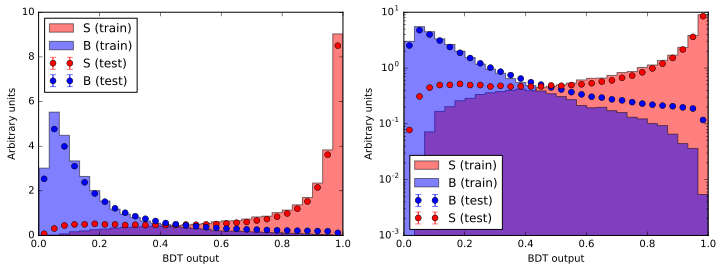

In [12]:
figsize(12, 4)
compare_train_test(est, X_train, y_train, X_test, y_test)

/grid_mnt/opt__exp_soft/cms/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


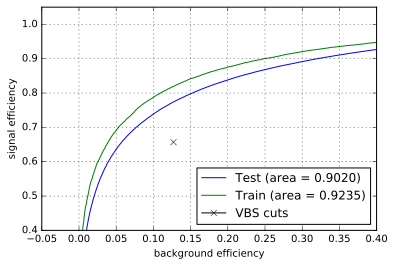

In [67]:
figsize(6, 4)
def plot_ROC(est, X_test, y_test, X_train=None, y_train=None) : 
    from sklearn.metrics import auc
    est_decisions = est.predict_proba(X_test)[:, 1]
    est_fpr, est_tpr, thresholds = roc_curve(y_test, est_decisions)
    roc_auc = auc(est_fpr, est_tpr)
    
    plt.plot(est_fpr, est_tpr, lw=1, label = 'Test (area = %0.4f)'%(roc_auc))
    if X_train!=None and y_train!=None :
        est_decisions_train = est.predict_proba(X_train)[:, 1]
        est_fpr_train, est_tpr_train, _ = roc_curve(y_train, est_decisions_train)
        roc_auc_train = auc(est_fpr_train, est_tpr_train)
        plt.plot(est_fpr_train, est_tpr_train, lw=1, label = 'Train (area = %0.4f)'%(roc_auc_train))
    #plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.plot(0.127, 0.657, lw=1,marker = 'x', label='VBS cuts', color = 'black')

    plt.xlim([-0.05, .4])
    plt.ylim([0.4, 1.05])
    plt.xlabel('background efficiency')
    plt.ylabel('signal efficiency')
    plt.legend(loc="best", numpoints = 1)
    plt.grid()
    plt.show()
    
plot_ROC(est, X_test, y_test, X_train, y_train) 

In [73]:
from math import log
def get_significance(tpr, fpr, s_fid_s, s_fid_b) :
    N_s = tpr*s_fid_s
    N_b = fpr*s_fid_b
    
    lnQ= -N_s + (N_s + N_b) * np.log(1 + N_s/N_b)
    s = lnQ**0.5   
     
    #denom = num + fpr*s_fid_b
    #denom = denom**0.5
    
    return s

In [74]:
s_fid_s = 0.1986
s_fid_b = 2.602

luminosity = 30.

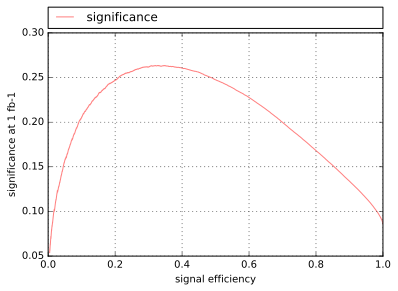

Maximum of S/(S+B)**0.5 is at :  0.263520721886
Signal eff  0.326732010188
Background eff  0.00567817228377
Expected signal events at 30fb-1  1.9466693167
Expected background events at 30fb-1  0.443238128471
BDT cut value  0.950911801865


In [75]:
    figsize(6, 4)
    significance = get_significance(est_tpr[100:-10], est_fpr[100:-10], s_fid_s, s_fid_b)
    significance[significance > 5] = 0
    plt.plot(est_tpr[100:-10], significance, alpha=0.5, color = 'red', label='significance')
    plt.ylabel('significance at 1 fb-1')
    plt.xlabel('signal efficiency')
    #plt.title('Receiver operating characteristic')
    #plt.legend(loc="best")
    plt.legend().set_visible(False)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    #plt.legend(numpoints=1)
    plt.grid()
    plt.show()
    significance_WP = np.max(significance)
    WP = np.argmax(significance)
    BDT_WP = thresholds[WP]
    print 'Maximum of S/(S+B)**0.5 is at : ', significance_WP

    print 'Signal eff ', est_tpr[WP]
    print 'Background eff ', est_fpr[WP]
    
    exp_sig_at_30 = luminosity*s_fid_s*est_tpr[WP]
    exp_bkg_at_30 = luminosity*s_fid_b*est_fpr[WP]
    
    print 'Expected signal events at 30fb-1 ', exp_sig_at_30
    print 'Expected background events at 30fb-1 ', exp_bkg_at_30    
    print 'BDT cut value ', BDT_WP

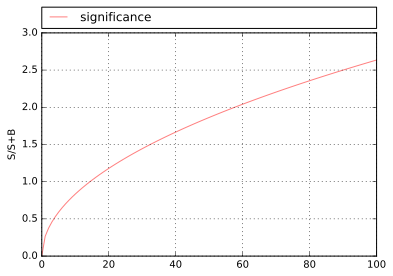

In [76]:
    lum = np.linspace(0, 100, 100)
    s_fid_s = 0.2115230295 #0.1986
    s_fid_b = 2.66579147967 #2.602
    plt.plot(lum, lum**0.5 * significance_WP, alpha=0.5, color = 'red', label='significance')
#plt.locator_params(nbins=10)
#plt.locator_params(axis='y',nbins=20)
#plt.plot(gbdt_fpr, gbdt_tpr, lw=1, label='GBDT')
#plt.xlim([-0.0, 0.45])
#plt.ylim([-0.05, 1.05])
    plt.ylabel('S/S+B')
    #plt.title('Receiver operating characteristic')
    #plt.legend(loc="best")
    plt.legend().set_visible(False)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    #plt.legend(numpoints=1)
    plt.grid()
    plt.show()

In [77]:
pass_bkg = est_decisions[y_test < 0.5] > BDT_WP
pass_sig = est_decisions[y_test > 0.5] > BDT_WP

X_test_bkg = X_test[y_test < 0.5]
X_test_sig = X_test[y_test > 0.5]

pass_bkg_weight = exp_bkg_at_30 / sum(pass_bkg) * np.ones(np.shape(X_test_bkg[pass_bkg,0]))
pass_sig_weight = exp_sig_at_30  / sum(pass_sig) * np.ones(np.shape(X_test_sig[pass_sig,0]))

bkg_weight = luminosity*s_fid_b / sum(np.ones(np.shape(X_test_bkg[:,0]))) * np.ones(np.shape(X_test_bkg[:,0]))
sig_weight = luminosity*s_fid_s  / sum(np.ones(np.shape(X_test_sig[:,0]))) * np.ones(np.shape(X_test_sig[:,0]))

print 'sum weights ', sum(bkg_weight)
print 'sum weights pass ', sum(pass_bkg_weight)

print 'sum weights ', sum(sig_weight)
print 'sum weights pass ', sum(pass_sig_weight)


sum weights  79.9737443908
sum weights pass  0.443238128471
sum weights  6.34569088507
sum weights pass  1.9466693167


signal overflow:  0 in event counts at 30fb  0.0
background overflow:  0 in event counts at 30fb  0.0


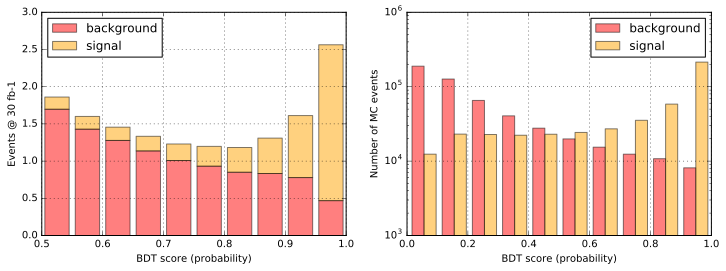

In [86]:
BDT_bkg = est_decisions[y_test < 0.5]
BDT_sig = est_decisions[y_test > 0.5]

min_BDT = 0.5
max_BDT = 1
bins_BDT = 10


figsize(12,4)
plt.subplot(121)
n, _, _ = plt.hist([BDT_bkg, BDT_sig], 
         bins=bins_BDT, range=(min_BDT, max_BDT) , weights = [bkg_weight, sig_weight]
         , lw=1, alpha=0.5, color = ['red', 'orange'], label=['background', 'signal'], stacked = True)
plt.xlabel('BDT score (probability)')
plt.ylabel('Events @ 30 fb-1')
plt.legend(loc="best")
plt.grid()
ax =plt.subplot(122)
ax.set_yscale("log", nonposy='clip')
plt.hist([BDT_bkg, BDT_sig], 
         bins=bins_BDT 
         , lw=1, alpha=0.5, color = ['red', 'orange'], label=['background', 'signal'])
plt.xlabel('BDT score (probability)')
plt.ylabel('Number of MC events')
plt.legend(loc="best")
plt.grid()

print 'signal overflow: ', sum(BDT_sig > max_BDT), 'in event counts at 30fb ', sum(sig_weight*(BDT_sig > max_BDT))
print 'background overflow: ', sum(BDT_bkg > max_BDT), 'in event counts at 30fb ', sum(bkg_weight*(BDT_bkg > max_BDT))


sigma:  2.39929718876


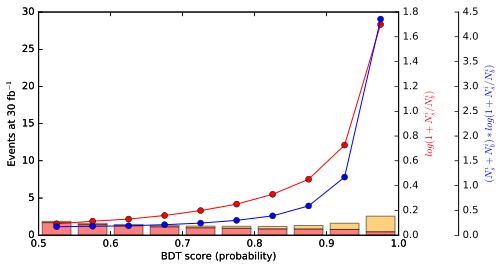

In [87]:
figsize(8,4)
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

N_b = n[0]
N_s = n[1] - n[0] # second histo is stack!

weight = np.log(1 + N_s / N_b)
second_term = (N_s + N_b)* weight


from __future__ import division
middle = (max_BDT - min_BDT) / bins_BDT / 2
sigma = -sum(N_s) + sum(second_term)
sigma = (2*sigma)**0.5
print 'sigma: ', sigma



host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 60
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(offset, 0))

par2.axis["right"].toggle(all=True)

host.set_xlim(min_BDT, max_BDT)
host.set_ylim(0, 30)

host.set_xlabel("BDT score (probability)")
host.set_ylabel(r'Events at 30 fb$^{-1}$')
par1.set_ylabel(r'$log(1 + N_s^i / N_b^i)$')
par2.set_ylabel(r'$(N_s^i + N_b^i) * log(1 + N_s^i / N_b^i)$')

p1 = host.hist([BDT_bkg, BDT_sig], 
         bins=bins_BDT, range=(min_BDT, max_BDT) , weights = [bkg_weight, sig_weight]
         , lw=1, alpha=0.5, color = ['red', 'orange'], label=['background', 'signal'], stacked = True)
p2, = par1.plot(np.linspace(min_BDT + middle, max_BDT + middle , bins_BDT, endpoint=False), weight , '-ro')
p3, = par2.plot(np.linspace(min_BDT + middle, max_BDT + middle , bins_BDT, endpoint=False), second_term , '-bo')


par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())

In [80]:

plots = [(r'$m_{jj}$ [GeV]', 3 , [0, 3000]),
         (r'$\Delta\eta_{jj}$', 20, [-10, 10]),
         (r'$m_{4l}$', 20, [0, 2000]),
         (r'$\eta^{*}_{Z_{1}}$', 10, [-5, 5]),
         (r'$\eta^{*}_{Z_{2}}$', 10, [-5, 5]),
         (r'$\Delta\phi(Z_{1}, Z_{2})$', 10, [-5,5]),
         (r'$\eta_{j_{1}}\times\eta_{j_{2}}$', 20, [-10, 10]),
         (r'$\cos{\theta^*}$', 22, [-1.1, 1.1]),
         (r'$\Phi$', 20, [-3.3, 3.3]),
         (r'$\cos \theta_1$', 22, [-1.1, 1.1]),
         (r'$\cos \theta_2$', 22, [-1.1, 1.1]),
         (r'$\Phi_1$', 20, [-3.3, 3.3]),
         (r'$VBF \cos{\theta^*}$', 22, [-1.1, 1.1]),
         (r'$VBF \cos \theta_1$', 22, [-1.1, 1.1]),
         (r'$VBF \cos \theta_2$', 22, [-1.1, 1.1]),
         (r'$VBF \Phi$', 20, [-3.3, 3.3]),
         (r'$VBF \Phi_1$', 20, [-3.3, 3.3]),
         (r'$q_{V1}$ [GeV]', 30 , [0, 3000]),
         (r'$q_{V2}$ [GeV]', 30 , [0, 3000]),         
        ]



def plot_BDT_selection(plot_index) :
    figsize(18, 4)
    p = plots[plot_index]
    plt.subplot(131)
    plt.hist(X_test_sig[:,plot_index]        , bins=p[1], range=p[2], weights = sig_weight, lw=1, alpha=0.5, color = 'navy', label='all')
    plt.hist(X_test_sig[pass_sig, plot_index], bins=p[1], range=p[2] , weights = pass_sig_weight, lw=1, alpha=0.5, color = 'blue', label='pass BDT')
    #plt.hist(red_sig[:,0], bins=p[1], range=p[2], normed=1, lw=1, alpha=0.5, color = 'blue', label='sig')
    plt.xlabel(p[0])
    plt.ylabel('Events @ 30 fb-1')
    plt.legend(loc="best")
    plt.title("Signal")
    plt.grid()


    plt.subplot(132)
    plt.hist(X_test_bkg[:,plot_index]        , bins=p[1], range=p[2], weights = bkg_weight, lw=1, alpha=0.5, color = 'navy', label='all')
    plt.hist(X_test_bkg[pass_bkg, plot_index], bins=p[1], range=p[2] , weights = pass_bkg_weight, lw=1, alpha=0.5, color = 'blue', label='pass BDT')
    #plt.hist(red_sig[:,0], bins=p[1], range=p[2], normed=1, lw=1, alpha=0.5, color = 'blue', label='sig')
    plt.xlabel(p[0])
    plt.ylabel('Events @ 30 fb-1')
    plt.title("Background")
    plt.legend(loc="best")
    plt.yscale('log', nonposy='clip')
    plt.grid()


    plt.subplot(133)
    n, _, _ = plt.hist([X_test_bkg[pass_bkg, plot_index], X_test_sig[pass_sig, plot_index]], 
             bins=p[1], range=p[2] , weights = [pass_bkg_weight, pass_sig_weight]
             , lw=1, alpha=0.5, color = ['red', 'orange'], label=['background', 'signal'], stacked = True)

    plt.xlabel(p[0])
    plt.ylabel('Events @ 30 fb-1')
    plt.title("BDT selection")
    plt.legend(loc="best")
    plt.grid()
    
    N_b = n[0]
    N_s = n[1] - n[0] # second histo is stack!

    print 'sigma: ', get_ln_significance(N_s, N_b)

    plt.show()

In [81]:
import pickle


#pickle.dump(gbdt, open( "gbdt_best.pkl", "wb" ))
def get_ln_significance(N_s, N_b) :
    weight = np.log(1 + N_s / N_b)
    second_term = (N_s + N_b)* weight
    sigma = -sum(N_s) + sum(second_term)
    sigma = (2*sigma)**0.5
    return sigma

sigma:  1.95184315323


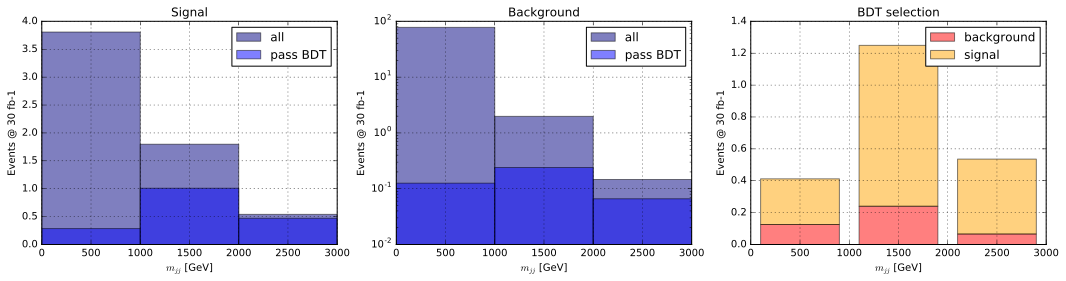

In [82]:
plot_BDT_selection(0) # mjj

sigma:  nan


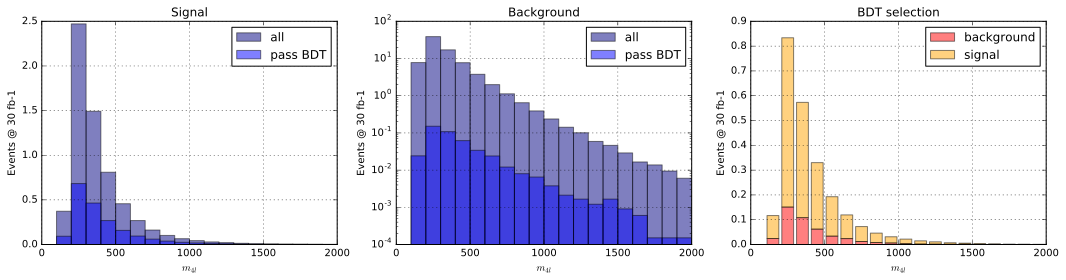

In [83]:
plot_BDT_selection(2) # m4l